In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
df = pd.read_parquet("hf://datasets/dair-ai/emotion/unsplit/train-00000-of-00001.parquet")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
df

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
4,i beleive that i am much more sensitive to oth...,2
...,...,...
416804,that was what i felt when i was finally accept...,1
416805,i take every day as it comes i m just focussin...,4
416806,i just suddenly feel that everything was fake,0
416807,im feeling more eager than ever to claw back w...,1


In [4]:
# Balance dataset - sample 20000 from each class except class 5
label_0_sample = df[df['label'] == 0].sample(n=20000, random_state=42)
label_1_sample = df[df['label'] == 1].sample(n=20000, random_state=42)
label_2_sample = df[df['label'] == 2].sample(n=20000, random_state=42)
label_3_sample = df[df['label'] == 3].sample(n=20000, random_state=42)
label_4_sample = df[df['label'] == 4].sample(n=20000, random_state=42)
other_labels = df[df['label'] == 5]

In [5]:
balanced_df = pd.concat([label_0_sample, label_1_sample, label_2_sample,
                         label_3_sample, label_4_sample, other_labels])
balanced_df = balanced_df.reset_index(drop=True)

<ipython-input-6-7947721d2b73>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.index, y=label_counts.values,


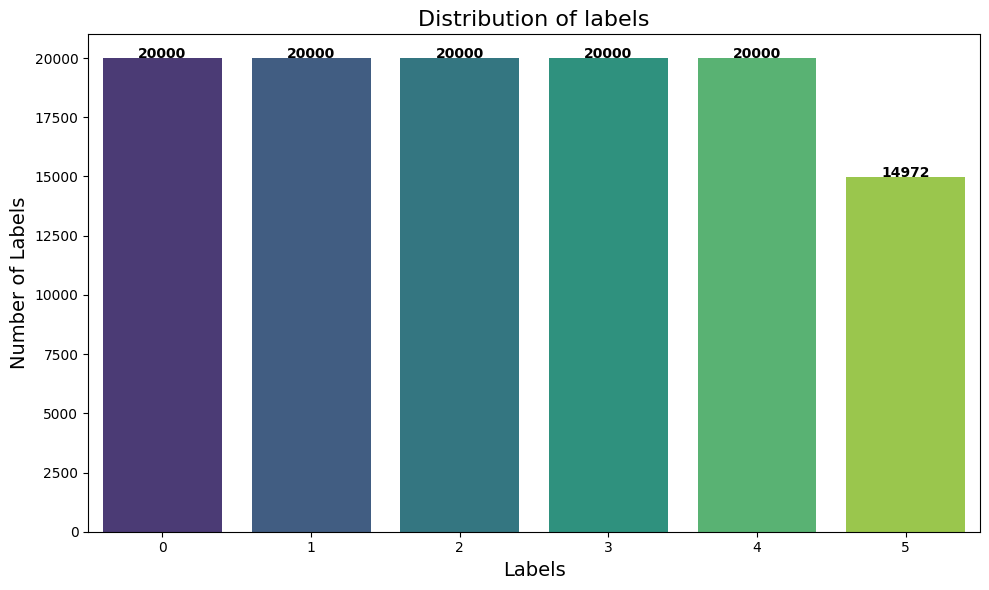

In [6]:
# Visualize data distribution
plt.figure(figsize=(10, 6))
label_counts = balanced_df['label'].value_counts().sort_index()
ax = sns.barplot(x=label_counts.index, y=label_counts.values,
                 palette=sns.color_palette("viridis", 6))

for i, count in enumerate(label_counts.values):
    ax.text(i, count + 5, str(count), ha='center', fontweight='bold')

plt.title("Distribution of labels", fontsize=16)
plt.xlabel("Labels", fontsize=14)
plt.ylabel("Number of Labels", fontsize=14)
plt.tight_layout()
plt.show()

In [7]:
X = balanced_df['text']
y = balanced_df['label']

In [8]:
MAX_WORDS = 10000
sequence_tokenizer = Tokenizer(num_words=MAX_WORDS)
sequence_tokenizer.fit_on_texts(X)

In [9]:
# Convert text to numeric sequences and pad
MAX_SEQUENCE_LENGTH = 128
X_sequences = sequence_tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [10]:
# Save tokenizer for inference
import pickle
with open('emotion_tokenizer.pickle', 'wb') as handle:
    pickle.dump(sequence_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
import json
tokenizer_json = sequence_tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer_json)

In [11]:
# Split data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.3, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.125, random_state=42
)

In [13]:
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 70420 samples
Validation set: 10060 samples
Test set: 34492 samples


In [14]:
# Build GRU model
gru_model = Sequential([
    # Input embedding layer
    Embedding(input_dim=MAX_WORDS, output_dim=64, input_length=MAX_SEQUENCE_LENGTH),

    # Regularization - keeping SpatialDropout1D as it's good for text data
    SpatialDropout1D(0.3),

    # GRU layer
    GRU(128, dropout=0.3, recurrent_dropout=0.2),

    # Output layer (6 classes)
    Dense(6, activation='softmax')
])

# Compile model
gru_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=0.0001
    )
]

# Train model
history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    verbose=1,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 245s 429ms/step - accuracy: 0.4759 - loss: 1.2832 - val_accuracy: 0.9431 - val_loss: 0.1596 - learning_rate: 0.0010
Epoch 2/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 224s 369ms/step - accuracy: 0.9334 - loss: 0.1857 - val_accuracy: 0.9487 - val_loss: 0.1262 - learning_rate: 0.0010
Epoch 3/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 266s 377ms/step - accuracy: 0.9451 - loss: 0.1360 - val_accuracy: 0.9499 - val_loss: 0.1208 - learning_rate: 0.0010
Epoch 4/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 207s 376ms/step - accuracy: 0.9484 - loss: 0.1226 - val_accuracy: 0.9484 - val_loss: 0.1166 - learning_rate: 0.0010
Epoch 5/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 265s 381ms/step - accuracy: 0.9518 - loss: 0.1074 - val_accuracy: 0.9477 - val_loss: 0.1196 - learning_rate: 0.0010
Epoch 6/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 259s 376ms/step - accuracy: 0.9560 - loss: 0.0998 - val_accuracy: 0.9454 - val_loss: 0.1212 - learning_rate: 0.0010
Epoch 7/10
551/551 ━━━━━━━━━━━━━━━━━━━━ 265s 382ms/step - accura

In [15]:
print("\nEvaluating model on test set:")
test_loss, test_acc = gru_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


Evaluating model on test set:
1078/1078 ━━━━━━━━━━━━━━━━━━━━ 79s 73ms/step - accuracy: 0.9478 - loss: 0.1230
Test accuracy: 0.9476


In [16]:
y_pred = np.argmax(gru_model.predict(X_test), axis=1)

1078/1078 ━━━━━━━━━━━━━━━━━━━━ 79s 73ms/step


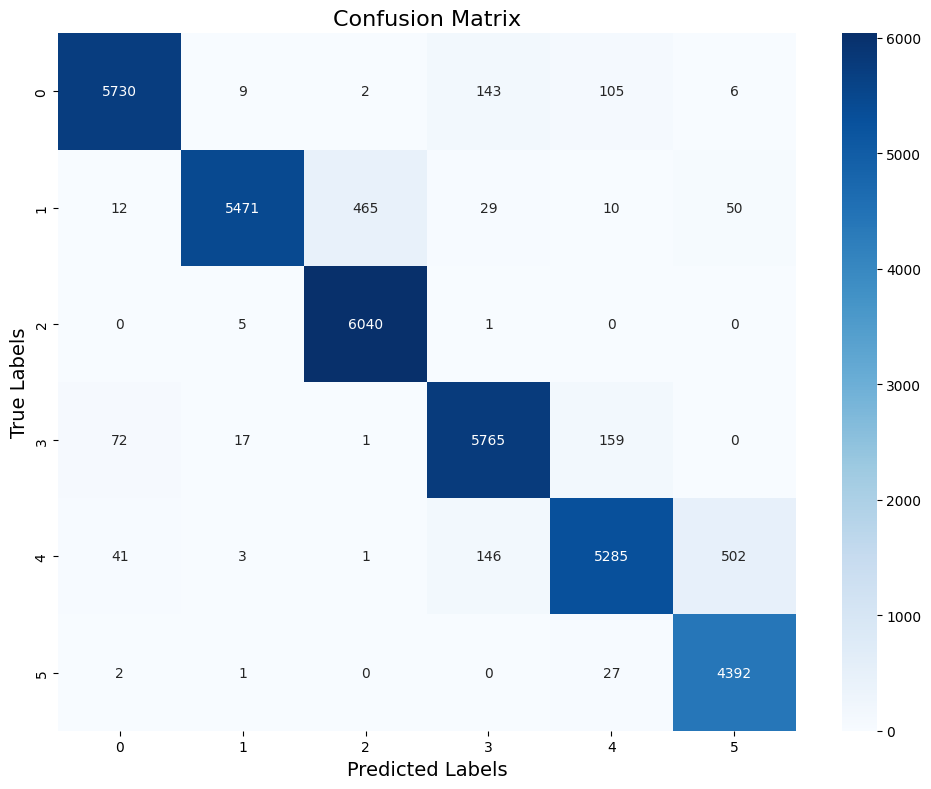

In [17]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(6), yticklabels=range(6))
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.tight_layout()
plt.show()

In [18]:
print("\nClassification Report:")
target_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']  # Based on dair-ai/emotion dataset
report = classification_report(y_test, y_pred, target_names=target_names)
print(report)


Classification Report:
              precision    recall  f1-score   support

     sadness       0.98      0.96      0.97      5995
         joy       0.99      0.91      0.95      6037
        love       0.93      1.00      0.96      6046
       anger       0.95      0.96      0.95      6014
        fear       0.95      0.88      0.91      5978
    surprise       0.89      0.99      0.94      4422

    accuracy                           0.95     34492
   macro avg       0.95      0.95      0.95     34492
weighted avg       0.95      0.95      0.95     34492



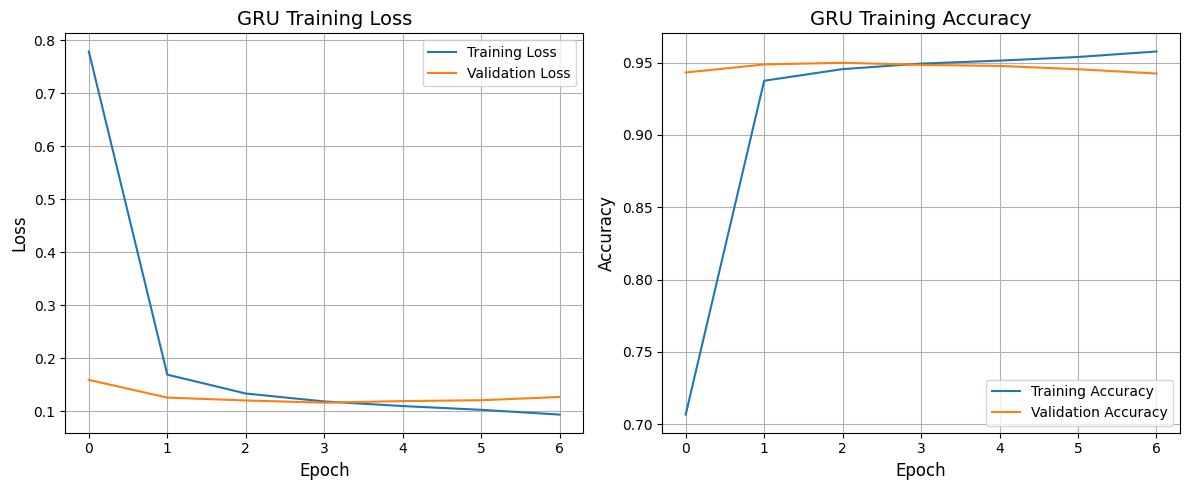

In [19]:
# Visualize training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GRU Training Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('GRU Training Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
gru_model.save('saved_model/emotion_model.h5')
print("Model saved in HDF5 format")

Model saved in HDF5 format


In [32]:
gru_model.save('saved_model/emotion_model.keras')
print("Model saved in native Keras format")

Model saved in native Keras format


In [24]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [25]:
import tensorflowjs as tfjs

In [26]:
# Save model in TensorFlow.js format
tfjs.converters.save_keras_model(gru_model, 'tfjs_model')
print("Model saved in TensorFlow.js format")

failed to lookup keras version from the file,
    this is likely a weight only file
Model saved in TensorFlow.js format


In [27]:
# Inference example
def predict_emotion(text):
    # Preprocess the text
    sequences = sequence_tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    # Predict
    prediction = gru_model.predict(padded)[0]
    emotion_index = np.argmax(prediction)

    emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
    return {
        'emotion': emotions[emotion_index],
        'confidence': float(prediction[emotion_index]),
        'all_probabilities': {emotion: float(prob) for emotion, prob in zip(emotions, prediction)}
    }

In [31]:
test_texts = [
    "just trying to take each day as it comes, focusing on eating better. not setting crazy goals or deadlines that stress me out, just improving my diet little by little #selfcare",
    "that feeling when i finally got accepted to the bulgarian conservatory after applying for years! can't believe it finally happened #dreams",
    "i literally can't stand having violent thoughts, they make me so uncomfortable #anxiety",
    "can't predict her impact on the group like chizuru had, but she's mysterious yet transparent and i'm getting excited about being surprised #anime #relationships",
    "my body is screaming for sleep, aching and dying but my brain refuses to shut down #insomnia #exhausted",
    "im feeling more eager than ever to claw back what went pear shaped last week and get back on track"
]

print("\nInference Examples:")
for text in test_texts:
    result = predict_emotion(text)
    print(f"Text: {text}")
    print(f"Predicted emotion: {result['emotion']} (confidence: {result['confidence']:.4f})")
    print("-" * 50)


Inference Examples:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Text: just trying to take each day as it comes, focusing on eating better. not setting crazy goals or deadlines that stress me out, just improving my diet little by little #selfcare
Predicted emotion: anger (confidence: 0.4040)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Text: that feeling when i finally got accepted to the bulgarian conservatory after applying for years! can't believe it finally happened #dreams
Predicted emotion: love (confidence: 0.8904)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Text: i literally can't stand having violent thoughts, they make me so uncomfortable #anxiety
Predicted emotion: fear (confidence: 0.7846)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Text: can't predict her impact on the group like chizuru had, but she's mysterious yet transparent and i'm gettin